#### OSQP Version of the combined MPC and trajectory planner

In [20]:
import casadi as ca
import numpy as np
from scipy import sparse
import control as ct
import osqp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [148]:
## Linearisation

x = ca.SX.sym("x", 12)
u = ca.SX.sym("u", 4)

m = 2.23  # kg
g = 9.8  # m/s^2
#Ix, Iy, Iz = 0.11, 0.11, 0.04  # kg m^2
## NEW - from gz sdf model
Ix = 0.008
Iy = 0.015
Iz = 0.017

l = 0.2  # m (this drops out when controlling via torques)
dt=0.1
## New step size
#dt=0.01

## REMOVE
parms = {"Q": np.eye(12), "R": np.eye(4), "N": 10, "Qf": np.eye(12), "dynamic": True}

# non linear dynamics
x_x, x_y, x_z, x_phi, x_theta, x_psi, x_dx, x_dy, x_dz, x_dphi, x_dtheta, x_dpsi = ca.vertsplit(x, 1)
u_F, u_Tx, u_Ty, u_Tz = ca.vertsplit(u, 1)

dx_x = x_dx
dx_y = x_dy
dx_z = x_dz
dx_phi = x_dphi
dx_theta = x_dtheta
dx_psi = x_dpsi

## Added -1 for new refeerence frame
'''
dx_dx = -1*u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
dx_dy = -1*u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.sin(x_psi)+ca.sin(x_phi)*ca.cos(x_psi))
## Added +g
dx_dz = -1*u_F/m * ca.cos(x_phi) * ca.cos(x_theta) + g
'''

#### NEW DYNAMICS
#dx_dx = -1*u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
#dx_dy = -1*u_F/m * (ca.cos(x_psi)*ca.sin(x_theta)*ca.sin(x_phi) - ca.sin(x_psi)*ca.cos(x_phi))
#dx_dz = -1*u_F/m * ca.cos(x_psi) * ca.cos(x_theta) + g

## 2nd dynamics
dx_dx = -1*u_F/m * (ca.sin(x_theta))
dx_dy = -1*u_F/m * (-ca.sin(x_phi)*ca.cos(x_theta))
dx_dz = -1*u_F/m * (ca.cos(x_phi) * ca.cos(x_theta)) + g


dx_dphi = 1/Ix * (u_Tx + x_dtheta * x_dpsi*(Iy - Iz))
dx_dtheta = 1/Iy * (u_Ty + x_dpsi*x_dphi*(Iz - Ix))
dx_dpsi = 1/Iz * (u_Tz + x_dphi*x_dtheta*(Ix-Iy))

x_dot = ca.vertcat(dx_x, dx_y, dx_z, dx_phi, dx_theta, dx_psi, dx_dx, dx_dy, dx_dz, dx_dphi, dx_dtheta, dx_dpsi)
f = x_dot
dynamics = ca.Function("quadrotor_dyn", [x, u], [x + dt * x_dot])

# this is continuous or discrete time?
#jac_dyn_x = ca.jacobian(self.x + self.dt * x_dot, self.x)
#jac_dyn_u = ca.jacobian(self.x + self.dt * x_dot, self.u)
#self.jac_dyn_x = ca.Function("jac_dyn_x", [self.x, self.u], [jac_dyn_x])
#self.jac_dyn_u = ca.Function("jac_dyn_u", [self.x, self.u], [jac_dyn_u])

x_operating = np.zeros((12, 1))
u_operating = np.array([m*9.8, 0, 0, 0]).reshape((-1, 1))  # hovering (mg 0 0 0)

A = ca.Function("A", [x, u], [ca.jacobian(f, x)])(x_operating, u_operating)
B = ca.Function("B", [x, u], [ca.jacobian(f, u)])(x_operating, u_operating)
C = np.eye(12)
D = np.zeros((12, 4))

#make numerical matrices and cast into numpy array
A = np.array(ca.DM(A))
B = np.array(ca.DM(B))

lin_ss_cont = ct.ss(A,B,C,D)
lin_ss_disc = ct.c2d(lin_ss_cont,dt,method='zoh')

#print(lin_ss_disc)
#print(type(lin_ss_disc.A), lin_ss_disc.A.shape)

print(lin_ss_disc.A.shape)
for i in range(0,12):
    for j in range(0,12):
        print(lin_ss_disc.A[i][j], end=' ')
    print()

print(lin_ss_disc.B.shape)
for i in range(0,12):
    for j in range(0,4):
        print(lin_ss_disc.B[i][j], end=' ')
    print()

''' Conversion of A and B matrices to cpp code
print(lin_ss_disc.B.shape)
for i, e in enumerate(lin_ss_disc.A):
    for j, ent in enumerate(e):
        print(f'{ent}, #A({i},{j})')

for i, e in enumerate(lin_ss_disc.B):
    for j, ent in enumerate(e):
        print(f'{ent}, #B({i},{j})')
'''


(12, 12)
1.0 0.0 0.0 0.0 -0.049 0.0 0.09999999999999999 0.0 0.0 0.0 -0.0016333333333333334 0.0 
0.0 1.0 0.0 0.049 0.0 0.0 0.0 0.09999999999999999 0.0 0.0016333333333333334 0.0 0.0 
0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.09999999999999999 0.0 0.0 0.0 
0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.09999999999999999 0.0 0.0 
0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.09999999999999999 0.0 
0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.09999999999999999 
0.0 0.0 0.0 0.0 -0.9800000000000001 0.0 1.0 0.0 0.0 0.0 -0.049 0.0 
0.0 0.0 0.0 0.9800000000000001 0.0 0.0 0.0 1.0 0.0 0.049 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
(12, 4)
0.0 0.0 -0.0027222222222222222 0.0 
0.0 0.0051041666666666674 0.0 0.0 
-0.002242152466367713 0.0 0.0 0.0 
0.0 0.6249999999999999 0.0 0.0 
0.0 0.0 0.3333333333333333 0.0 
0.0 0.0 0.0 0.2941176470588235 
0.0 0.0 -0.10888888

" Conversion of A and B matrices to cpp code\nprint(lin_ss_disc.B.shape)\nfor i, e in enumerate(lin_ss_disc.A):\n    for j, ent in enumerate(e):\n        print(f'{ent}, #A({i},{j})')\n\nfor i, e in enumerate(lin_ss_disc.B):\n    for j, ent in enumerate(e):\n        print(f'{ent}, #B({i},{j})')\n"

For OSQP, we need to express our problem in a specific format:

$$\text{Minimise }\frac{1}{2}x^{T}Px+q^{T}x$$
$$\text{subject to }l\leq Ax\leq u$$

Need to define, P, l, u, and A

In [156]:
## NOTE We are assuming N=10 here - should probably generalise it

# Define problem data
## Change to np.diagonal
#p = np.block([[np.eye(120,120), np.zeros((120,40))],[np.zeros((40,120)), np.eye(40,40)]])
#p = np.block([[np.eye(120,120), np.zeros((120,40))],[np.zeros((40,120)), np.zeros((40,40))]])

#x_penalty = 10*[1,1,1,1,1,1,1,1,1,1,1,1]
x_penalty = 10*[10,10,10,2,2,2,5,5,5,2,2,2]
u_penalty = np.tile([0.1,0.1,0.1,0.1],10)

p = np.block([[np.diag(x_penalty), np.zeros((120,40))],[np.zeros((40,120)), np.diag(u_penalty)]])

## Increase TERMINAL constraint
for i in range(0,12):
    #p[108+i][108+i] = [10*e for e in x_penalty][i]
    p[108+i][108+i] = [1*e for e in x_penalty][i]

l = np.zeros((240,1))
u = np.zeros((240,1))
A = np.zeros((240,160))

## Arrays are addressed by (row, column)

## Part 1. Input limits (rows 0:40)
for i in range(0,40,4) :
    ## Added new constriants
    l[i] = -m*9.8 ## Due to change of variables during linearisation
    u[i] = 40-m*9.8
    l[i+1] = -1.475
    u[i+1] = 1.475
    l[i+2] = -1.475
    u[i+2] = 1.475
    l[i+3] = -0.0196
    u[i+3] = 0.0196
    
    A[i,120+i] = 1
    A[i+1,120+i+1] = 1
    A[i+2,120+i+2] = 1
    A[i+3,120+i+3] = 1

## Part 2. Roll/Pitch Angle limits (rows 40:60)
for i in range(0,10):
    l[40+2*i] = -np.pi/2
    u[40+2*i] = np.pi/2
    l[40+2*i+1] = -np.pi/2
    u[40+2*i+1] = np.pi/2

    A[40+2*i,12*i+3] = 1
    A[40+2*i+1,12*i+4] = 1

## Part 3. Velocity Constraints (rows 60:90)
for i in range(0,10):
    ## Updated from [-2,2]
    l[60+3*i] = -1e6
    u[60+3*i] = 1e6
    l[60+3*i+1] = -1e6
    u[60+3*i+1] = 1e6
    l[60+3*i+2] = -1e6
    u[60+3*i+2] = 1e6

    A[60+3*i,12*i+6] = 1
    A[60+3*i+1,12*i+7] = 1
    A[60+3*i+2,12*i+8] = 1

## Part 4. Angular Rate Constraints (rows 90:120)
for i in range(0,10):
    l[90+3*i] = -3*np.pi
    u[90+3*i] = 3*np.pi
    l[90+3*i+1] = -3*np.pi
    u[90+3*i+1] = 3*np.pi
    l[90+3*i+2] = -3*np.pi
    u[90+3*i+2] = 3*np.pi

    A[90+3*i,12*i+9] = 1
    A[90+3*i+1,12*i+10] = 1
    A[90+3*i+2,12*i+11] = 1

## Part 5. System Dynamics (as constraints) (rows 120:240)
for i in range(0,10):
    ## Add identity matrix
    A[120+12*i:120+12*(i+1),12*i:12*(i+1)] = np.eye(12)

    ## Add A matrix but skip in first iteration
    if i!=0:
        A[120+12*i:120+12*(i+1), 12*(i-1):12*i] = -1*lin_ss_disc.A

    ## Add B matrix
    A[120+12*i:120+12*(i+1), 120+4*i:120+4*(i+1)] = -1*lin_ss_disc.B

## NOTE This happens as part of iteration -- Part 6. Lower and upper with initial state (this is what gets updated each step)

## Convert to sparse matrix NOTE This should just be used originally
p = sparse.csc_matrix(p)
A = sparse.csc_matrix(A)

'''
q = np.array([1, 1])
A = sparse.csc_matrix([[1, 1], [1, 0], [0, 1]])
l = np.array([1, 0, 0])
u = np.array([1, 0.7, 0.7])

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace and change alpha parameter
prob.setup(P, q, A, l, u, alpha=1.0)

# Solve problem
res = prob.solve()
''';
#for i in range(0,240):
#    print(f'{u[i][0]}, // ({i},0)')
#print(A[0:40])

In [157]:
def generate_c_code(linA, linB, lower, upper):
    with open('../../../controller_mpc_constructor.cpp','w') as wfile:
        wfile.write("""#include "controller_mpc.h"

MPC_Controller::MPC_Controller()
    : MC_Controller(),
    linearised_A{
"""
                   )
        for i in range(0,12):
            for j in range(0,12):
                wfile.write(f"{linA[i,j]}f, // ({i},{j})\n")
        wfile.write("},\nlinearised_B{\n")
        for i in range(0,12):
            for j in range(0,4):
                wfile.write(f"{linB[i,j]}f, // ({i},{j})\n")
        wfile.write("},\nlower_constraint{\n")
        for i in range(0,240):
            wfile.write(f"{lower[i][0]}f, // ({i},0)\n")
        wfile.write("},\nupper_constraint{\n")
        for i in range(0,240):
            wfile.write(f"{upper[i][0]}f, // ({i},0)\n")
        ## Penalty vector
        wfile.write("},\npenalty_vector{\n")
        for i in range(0,120):
            wfile.write(f"{x_penalty[i]}.0f, // ({i},0)\n")
        wfile.write("}\n{\nfor (int i=0;i<160;i++) {\nq_constraint[i]=0.0f;\n}\n}\n")

#generate_c_code(lin_ss_disc.A, lin_ss_disc.B, l, u)

In [158]:
## Loop

## 20 seconds of iteration
num_iterations=int(20/dt)

u_loop = []
x_loop = []
statuses = []
solvetimes = []

# We use a 0.1s step time for 10 seconds (100 steps)
# Each step, we update the lower and upper matrix with the current state vector
# For reference tracking, we also need a q matrix to be updated with the state reference vector (for the states we are controlling)


x_ref = np.tile(np.array([4, 5, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0]),10)
x_ref = np.append(x_ref, np.zeros((40,1)))
q = -1*x_ref@p

prob = osqp.OSQP()
prob.setup(p, q, A, l, u, alpha=1.0, verbose=False)
prob.codegen('./cgen', force_rewrite=True)

x0 = np.array([3, 10, -2, 0.75, 0, 0, 0, 0, 0, 0, 0, 0])

for i in range(0,num_iterations):
    ## Store state vector for plotting
    x_loop.append(x0)
    
    ## Update l and u matrices
    l[120:120+12] = np.matmul(lin_ss_disc.A, x0).reshape((12,1))
    u[120:120+12] = np.matmul(lin_ss_disc.A, x0).reshape((12,1))

    ## Update q NOTE q (reference trajectory) is constant for now

    ## Update and solve
    prob.update(l=l, u=u, q=q)
    res = prob.solve()
    statuses.append(res.info.status)
    solvetimes.append(res.info.solve_time)

    ## Extract next control inputs
    u_next = res.x[120:124]
    u_loop.append(u_next)

    ## Recompute system dynamics
    #x0 = np.matmul(lin_ss_disc.A, x0)+np.matmul(lin_ss_disc.B,u_next)

    # add-back +mg from the linearised point
    u_next[0] += m*g
    x0 = dynamics(x0, u_next).full().reshape(12,)
    #print(x0.shape)
    #print(type(x0))

print(f'{sum([1 if e=='solved' else 0 for e in statuses])*100/len(statuses)}% solved')
print(f'Average solve time (ms): {1e3*sum(solvetimes)/len(solvetimes):4.6f}')
'''
for i in range(0,16):
    print(q[i*12:i*12+12])
''';


100.0% solved
Average solve time (ms): 0.093063


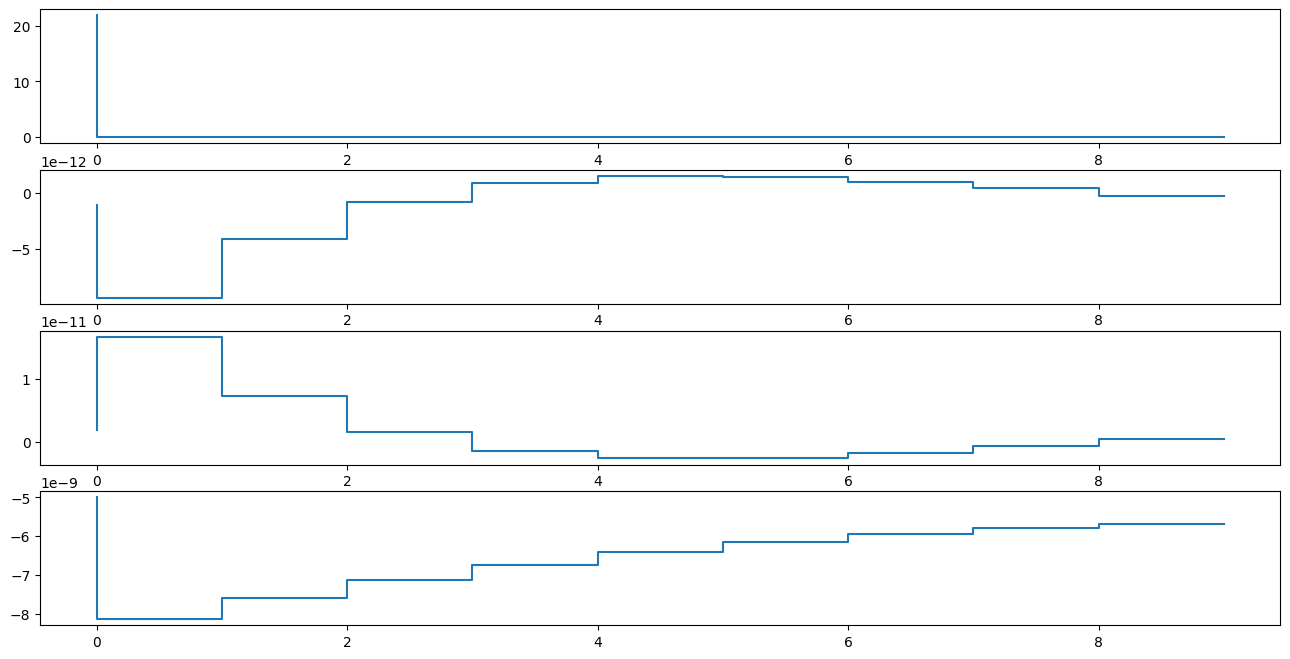

In [159]:
## Results plotting - next 10 input controls for a given step

res_f = [res.x[120+4*i] for i in range(0,10)]
res_roll = [res.x[120+4*i+1] for i in range(0,10)]
res_pitch = [res.x[120+4*i+2] for i in range(0,10)]
res_yaw = [res.x[120+4*i+3] for i in range(0,10)]

fig, axs = plt.subplots(4,1, figsize=(16,8))
axs[0].step(range(0,10), res_f, '#1f77b4', label=r'Total Thrust')
axs[1].step(range(0,10), res_roll, '#1f77b4', label=r'Total Thrust')
axs[2].step(range(0,10), res_pitch, '#1f77b4', label=r'Total Thrust')
axs[3].step(range(0,10), res_yaw, '#1f77b4', label=r'Total Thrust')
plt.show()

In [160]:
'''
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting (even if not used directly)
#from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Generate 3D parametric curve data
x = [x_loop[i][0] for i in range(0,100)]
y = [x_loop[i][1] for i in range(0,100)]
z = [x_loop[i][2] for i in range(0,100)]


# Create a 3D plot
fig = plt.figure(figsize=(12, 4), constrained_layout=True)

ax = fig.add_subplot(1,2,1, projection='3d')
ax.view_init(elev=20, azim=60)


xlim = (0, 10)
ylim = (0, 10)
zlim = (0, 10)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

# Define the face polygons
xy_plane = [[
    [xlim[0], ylim[0], zlim[0]],
    [xlim[1], ylim[0], zlim[0]],
    [xlim[1], ylim[1], zlim[0]],
    [xlim[0], ylim[1], zlim[0]]
]]
xz_plane = [[
    [xlim[0], ylim[0], zlim[0]],
    [xlim[1], ylim[0], zlim[0]],
    [xlim[1], ylim[0], zlim[1]],
    [xlim[0], ylim[0], zlim[1]]
]]
yz_plane = [[
    [xlim[0], ylim[0], zlim[0]],
    [xlim[0], ylim[1], zlim[0]],
    [xlim[0], ylim[1], zlim[1]],
    [xlim[0], ylim[0], zlim[1]]
]]

# Add colored planes
ax.add_collection3d(Poly3DCollection(xy_plane, color='red', alpha=0.1))
ax.add_collection3d(Poly3DCollection(xz_plane, color='green', alpha=0.1))
ax.add_collection3d(Poly3DCollection(yz_plane, color='blue', alpha=0.1))




# Plot the curve
ax.plot(x, y, z, label='Position', linestyle='--', color='purple')
ax.plot(0, y, z, label='Y-Z plane', color='blue')
ax.plot(x, 0, z, label='X-Z plane', color='green')
ax.plot(x, y, 0, label='X-Y plane', color='red')

# Optional: label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Position')
ax.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.step(np.linspace(0,10,100), u_loop, label=['Total Thrust', 'Roll', 'Pitch', 'Yaw'])
ax2.legend()
    
plt.show()
''';

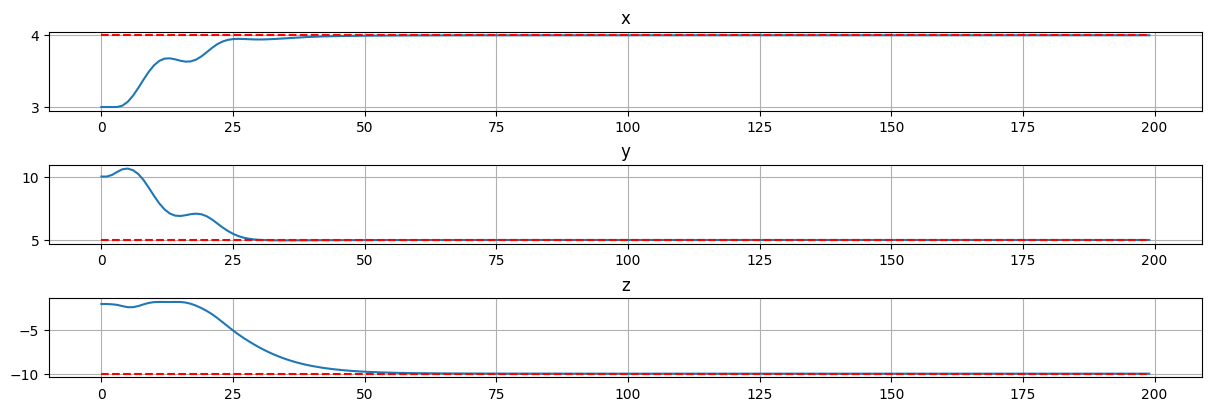

In [161]:
x = [x_loop[i][0] for i in range(0,num_iterations)]
y = [x_loop[i][1] for i in range(0,num_iterations)]
z = [x_loop[i][2] for i in range(0,num_iterations)]

fig = plt.figure(figsize=(12, 4), constrained_layout=True)

ax = fig.add_subplot(3,1,1)
ax.plot(range(0,len(x)),x, label='x')
ax.plot(range(0,len(x)), x_ref[0].repeat(num_iterations), linestyle='--', color='red')
ax.set_title('x')
ax.grid(True)

ax = fig.add_subplot(3,1,2)
ax.plot(range(0,len(y)),y)
ax.plot(range(0,len(y)), x_ref[1].repeat(num_iterations), linestyle='--', color='red')
ax.set_title('y')
ax.grid(True)

ax = fig.add_subplot(3,1,3)
ax.plot(range(0,len(z)),z)
ax.plot(range(0,len(z)), x_ref[2].repeat(num_iterations), linestyle='--', color='red')
ax.set_title('z')
ax.grid(True )

plt.show()

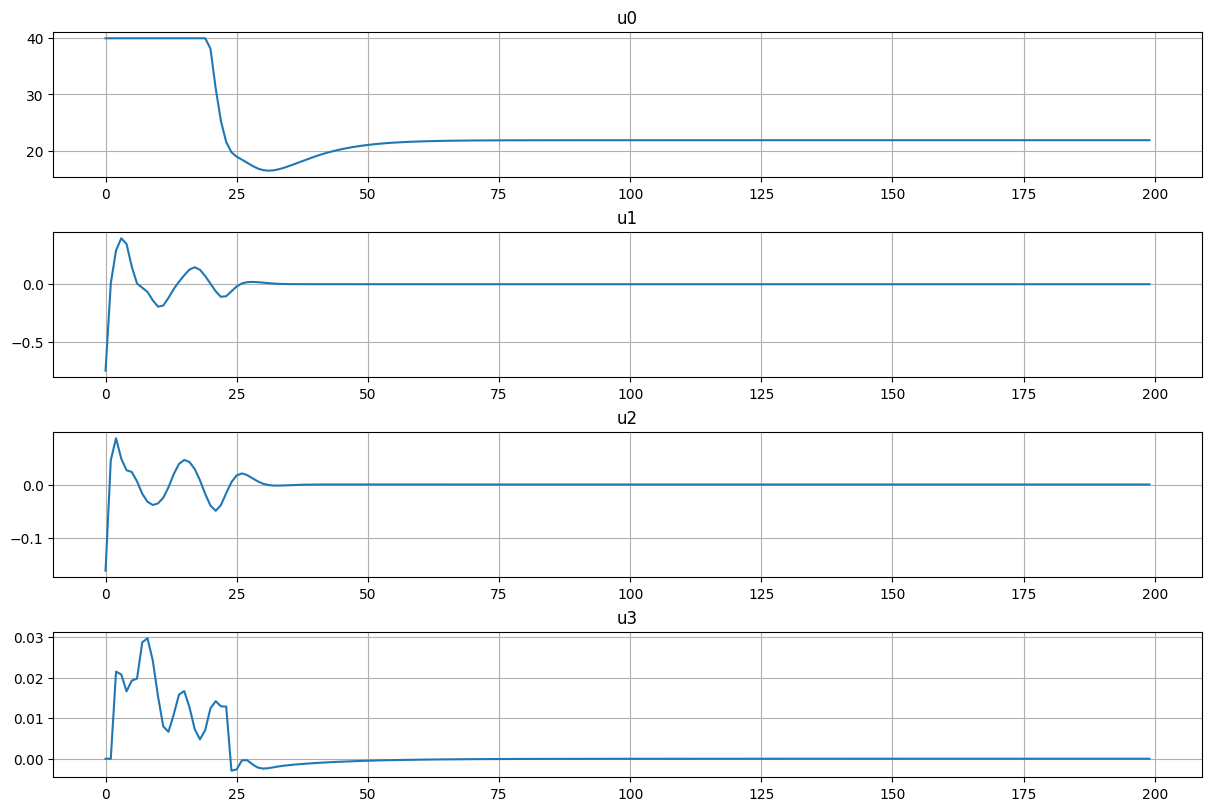

In [162]:
u0 = [u_loop[i][0] for i in range(0,num_iterations)]
u1 = [u_loop[i][1] for i in range(0,num_iterations)]
u2 = [u_loop[i][2] for i in range(0,num_iterations)]
u3 = [u_loop[i][3] for i in range(0,num_iterations)]

fig = plt.figure(figsize=(12, 8), constrained_layout=True)

ax = fig.add_subplot(4,1,1)
ax.plot(range(0,len(u0)),u0, label='x')
ax.set_title('u0')
ax.grid(True)

ax = fig.add_subplot(4,1,2)
ax.plot(range(0,len(u0)),u1, label='x')
ax.set_title('u1')
ax.grid(True)

ax = fig.add_subplot(4,1,3)
ax.plot(range(0,len(x)),u2, label='x')
ax.set_title('u2')
ax.grid(True)

ax = fig.add_subplot(4,1,4)
ax.plot(range(0,len(x)),u3, label='x')
ax.set_title('u3')
ax.grid(True)

plt.show()

In [90]:
### Mixer Algorithms
print(len(u_loop))

mixer = np.array([[1, -1, 1, 1],
                  [1, 1, -1, 1],
                  [1, 1, 1, -1],
                  [1, -1, -1, -1]])

ul_translated = np.array(u_loop)
ul_translated[:,0] += 9.8
print(ul_translated[0])
print(mixer@ul_translated[0])

200
[27.94675538 -0.75398051 -0.27436495  0.        ]
[28.42637094 27.46713982 26.91840992 28.97510084]


In [91]:
## Log the l, u, and q matrices to an output file as well as the linearised A and B matrices
with open('./outvec','w') as wfile:
    ## linearised A
    wfile.write(f'lin_A (12,12)\n')
    for i in range(0,12):
        for j in range(0,12):
            wfile.write(f'{lin_ss_disc.A[i,j]:+4.2f},')
        wfile.write('\n')

    ## linearised B
    wfile.write(f'lin_B (12,4)\n')
    for i in range(0,12):
        for j in range(0,4):
            wfile.write(f'{lin_ss_disc.B[i,j]:+4.2f},')
        wfile.write('\n')

    ## q_new
    wfile.write(f'q_new (1,160)\n')
    for i in range(0, 160):
        wfile.write(f'{q[i]:+4.2f},')
    wfile.write('\n')

    ## l
    wfile.write(f'l (240,1)\n')
    for i in range(0,240):
        wfile.write(f'{l[i,0]:+4.2f}\n')

    ## u
    wfile.write(f'u (240,1)\n')
    for i in range(0,240):
        wfile.write(f'{u[i,0]:+4.2f}\n')

    ## Constraint A matrix
    wfile.write(f'A (240,160)\n')
    for i in range(0,240):
        for j in range(0,160):
            wfile.write(f'{A[i,j]:+4.2f},')
        wfile.write('\n')
    